In [ ]:
from liblet import Tree, Grammar, Derivation, ProductionGraph, side_by_side

# La gerarchia di Chomsky

## Tipo 1

### Monotone

In [ ]:
# pag 20

monotonic = """
Sentence -> Name | List
List -> EndName | Name , List
Name -> tom | dick | harry
, EndName -> and Name
"""

In [ ]:
G_monotonic = Grammar.from_string(monotonic, False)
G_monotonic

Grammar(N={EndName, List, Name, Sentence}, T={,, and, dick, harry, tom}, P=(Sentence -> Name, Sentence -> List, List -> EndName, List -> Name , List, Name -> tom, Name -> dick, Name -> harry, , EndName -> and Name), S=Sentence)

### Context-sentitive

In [ ]:
# pag 20

context_sensitive = """
Sentence -> Name | List
List -> EndName | Name Comma List
Name -> tom | dick | harry
Comma EndName -> and EndName
and EndName -> and Name
Comma -> ,
"""

In [ ]:
G_cs = Grammar.from_string(context_sensitive, False)
G_cs

Grammar(N={Comma, EndName, List, Name, Sentence}, T={,, and, dick, harry, tom}, P=(Sentence -> Name, Sentence -> List, List -> EndName, List -> Name Comma List, Name -> tom, Name -> dick, Name -> harry, Comma EndName -> and EndName, and EndName -> and Name, Comma -> ,), S=Sentence)

In [ ]:
G_cs.P

(Sentence -> Name,
 Sentence -> List,
 List -> EndName,
 List -> Name Comma List,
 Name -> tom,
 Name -> dick,
 Name -> harry,
 Comma EndName -> and EndName,
 and EndName -> and Name,
 Comma -> ,)

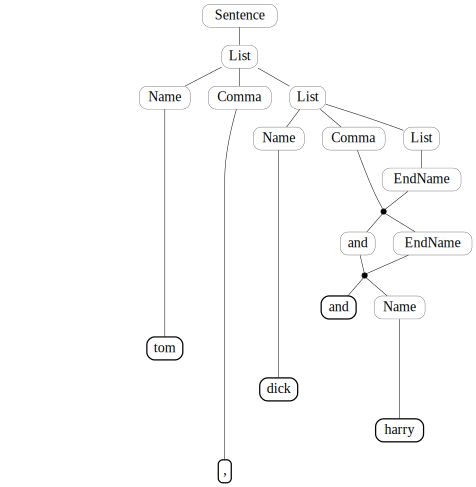

In [ ]:
steps = (1, 0), (3, 0), (3, 2), (2, 4), (7, 3), (8, 3), (4, 0), (5, 2), (6, 4), (9, 1)

d = Derivation(G_cs).step(steps)

ProductionGraph(d)

## Tipo 2 (Context-free)

In [ ]:
# pag 23

context_free = """
Sentence -> Name | List and Name
List -> Name , List | Name
Name -> tom | dick | harry
"""

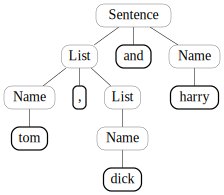

In [ ]:
steps = (1, 0), (2, 0), (3, 2), (4, 0), (5, 2), (6, 4)

G_cf = Grammar.from_string(context_free) # non c'è più il False

d = Derivation(G_cf).step(steps)

ProductionGraph(d) # finalmente un albero!

## Tipo 3 (Regolari)

In [ ]:
# fig. 2.14, pag. 31

regular = """
Sentence -> tom | dick | harry | List
List -> tom ListTail | dick ListTail | harry ListTail
ListTail -> , List | and tom | and dick | and henry
"""

regular_strict = """
Sentence -> tom | dick | harry | List
List -> tom ListTail | dick ListTail | harry ListTail
ListTail -> , List | and Tom | and Dick | and Henry
Tom -> tom
Dick -> dick
Henry -> henry
"""

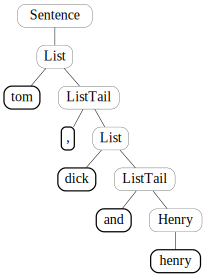

In [ ]:
G_regular = Grammar.from_string(regular_strict)

steps = (3, 0), (4, 0), (7, 1), (5, 2), (10, 3), (13, 4)

d = Derivation(G_regular).step(steps)

ProductionGraph(d) # una "lista"

# Generare le parole

In [ ]:
from liblet import Queue

In [ ]:
# compie max_step passi di visita in ampiezza del grafo
# implicito delle derivazioni, restituendo l'elenco di derivazioni
# che conducono ad una forma sentenziale composta solo di terminali

def produce(G, max_steps = 1):
    Q = Queue([Derivation(G)])
    D = [] 
    step = 0
    while Q and step <= max_steps:
      step += 1
      derivation = Q.dequeue()
      if set(derivation.sentential_form()) <= G.T: 
        D.append(derivation)
      else:
        for prod, pos in derivation.possible_steps():
            Q.enqueue(derivation.step(prod, pos))
    return D

In [ ]:
# la grammatica dell'esercizio facoltativo

G = Grammar.from_string("""
S -> a b c
S -> a S Q
b Q c -> b b c c
c Q -> Q c
""", False)

In [ ]:
# 10k passi per 42 derivazioni!

deriv = produce(G, 10_000)
len(deriv)

42

In [ ]:
# ma solo 5 parole distinte (come mai?)

words = set(''.join(d.sentential_form()) for d in deriv)
len(words)

5

In [ ]:
words

{'aaaaabbbbbccccc', 'aaaabbbbcccc', 'aaabbbccc', 'aabbcc', 'abc'}

# Fare pulizia nelle CF

## Una nozione di chiusura

Applicare il decoratore [@closure](https://liblet.readthedocs.io/en/latest/api.html#liblet.decorators.closure) ad una funzione `f`  produce una funzione `F` che corrisponde all'applicazione di `f` iterata sino a quando l'argomento ed il valore restituito da quest'ultima coincidono.

In [ ]:
from liblet import closure 

@closure
def add_smaller(S):
  return S | {x - 1 for x in S if x > 0}

In [ ]:
add_smaller({3, 5})

{0, 1, 2, 3, 4, 5}

## Eliminare simboli non produttivi e/o irraggiungibili

In [ ]:
# fig 2.27, pag. 49

G = Grammar.from_string("""
S -> A B | D E
A -> a
B -> b C
C -> c
D -> d F 
E -> e 
F -> f D
""")
G

Grammar(N={A, B, C, D, E, F, S}, T={a, b, c, d, e, f}, P=(S -> A B, S -> D E, A -> a, B -> b C, C -> c, D -> d F, E -> e, F -> f D), S=S)

In [ ]:
def find_productive(G):

  @closure
  def find(prod):
    return prod | {A for A, α in G.P if set(α) <= prod}

  return find(G.T)

find_productive(G)

frozenset({'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'})

In [ ]:
from liblet import union_of

def find_reachable(G):

  @closure
  def find(reach):
    return reach | union_of(set(α) for A, α in G.P if A in reach)

  return find({G.S})

find_reachable(G)

{'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

In [ ]:
def remove_unproductive_unreachable(G):
    Gp = G.restrict_to(find_productive(G))
    return Gp.restrict_to(find_reachable(Gp))

remove_unproductive_unreachable(G)

Grammar(N={A, B, C, S}, T={a, b, c}, P=(S -> A B, A -> a, B -> b C, C -> c), S=S)

# Derivazioni e alberi di parsing

In [ ]:
# una grammatica banale per il linguaggio {'ab'}

G_ab = Grammar.from_string("""
S -> A B
A -> a
B -> b
""")
G_ab

Grammar(N={A, B, S}, T={a, b}, P=(S -> A B, A -> a, B -> b), S=S)

In [ ]:
# due possibili derivazioni

ab_0 = Derivation(G_ab).step([
  (0, 0), (2, 1), (1, 0)
])
ab_1 = Derivation(G_ab).step([
  (0, 0), (1, 0), (2, 1)
])

ab_0, ab_1

(S -> A B -> A b -> a b, S -> A B -> a B -> a b)

In [ ]:
# ma a ben guardare lo stesso albero…

side_by_side(
  ProductionGraph(ab_0),
  ProductionGraph(ab_1),
)

## Dalla derivazione all'albero di parsing

La seguente procedura memorizza in `tree` l'albero di derivazione e in `frontier` la sua frontiera, corrispondente alla forma sentenziale a cui è giunta la derivazione (di passo in passo) come una lista di alberi annotati. 

Ciascun nodo dell'albero ha due etichette: `Symbol` che si riferisce ad uno dei simboli della grammatica e `nprord` pari ad un numero di produzione. I figli di ciascun nodo dell'albero hanno i simboli contenuti nel lato destro della produzione di numero `nprord`.

Gli alberi vengono "completati" man mano che la procedura elabora i passi della derivazione; al termine le foglie degli alberi saranno simboli terminali (e `nprord` sarà convenzionalmente definito come `None`).

In [ ]:
def derivation_to_parsetree(d):

    # questa variabile si riferià all'albero di derivazione di d
    # inizialmente contiene l'albero annotato col simbolo di partenza
    tree = Tree({'Symbol': d.G.S, 'nprod': None})

    # all'inizio la forma sentenziale è data da tale albero
    frontier = [tree, ] 

    for nprod, pos in d.steps():

        # i figli sono dati dal lato destro d.G.P[prod].rhs
        children = [Tree({'Symbol': X, 'nprod': None}) for X in d.G.P[nprod].rhs]

        # l'albero è dato dalla posizione in cui è applicata la produzione
        curr = frontier[pos]

        # si aggiornano l'albero e la forma sentenziale
        curr.root['nprod'] = nprod
        curr.children = children
        frontier = frontier[:pos] + children + frontier[pos + 1:]

    return tree

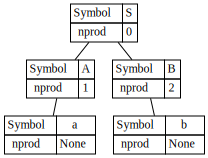

In [ ]:
pt_0 = derivation_to_parsetree(ab_0)
pt_0

In [ ]:
# l'albero di parsing prodotto da liblet, e da derivation_to_parsetree

side_by_side(
  ProductionGraph(ab_0),
  Tree.from_lol(pt_0)
)

## Dall'albero alle derivazioni (left- e right-most)

Le derivazioni leftmost e rightmost si possono ottenere, rispettivamente, tramite una visita in preordine e postordine dell'albero di parsing (la cui implementazoine è lasciata come esercizio)